In [2]:
import os
import re
import dotenv
import numpy as np
from numpy import inf
import pandas as pd
from pprint import pprint

# library for save and load scikit-learn models
import pickle

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import dtreeviz

In [22]:
# Load environment variables
project_dir = os.path.join(os.path.abspath(''), os.pardir)
dotenv_path = os.path.join(project_dir, '.env')

dotenv.load_dotenv(dotenv_path)

True

In [7]:
X = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/X_decision_trees.csv', encoding='utf-8')
y = pd.read_csv('/home/jovyan/git_projects/machine-learning-project/data/processed/y_both.csv', encoding='utf-8')

In [8]:
X = X.set_index('ID')
y = y.set_index('ID')

In [4]:
# X = df.loc[:, ["post_id", "log_init_imps", "log_init_engs", "Dominant_Topic", "Keywords"]]
# X = X.set_index('post_id')
# X = pd.concat([X.drop(columns=['Keywords']), X['Keywords'].str.get_dummies(sep=",")], axis=1)
# X = pd.concat([X.drop(columns=['Dominant_Topic']), X['Dominant_Topic'].astype(str).str.get_dummies()], axis=1)
# #X = pd.concat([df_ready.drop(columns=['Keywords']), df_ready['Keywords'].str.get_dummies(sep=",")], axis=1)
# #X = pd.concat([df_ready.drop(columns=['Dominant_Topic']), df_ready['Dominant_Topic'].str.get_dummies()], axis=1)
# y = df.loc[:, ["post_id", "log_all_engrate"]]
# y = y.set_index('post_id')
# y = y.squeeze()
# print(X.head())
# print(y.head())

                                                    log_init_imps  \
post_id                                                             
0958b102f46bf30d0fd0b066164da0b7b7bed762c4d7b75...       8.836810   
0e16a8e384fe24d1b936336efd87a978fd36ef241205a12...      10.852304   
149644004573512a361a5d89ab8c9003080a3af20fca364...       9.495219   
27df549b4d17af132fb603068a3cb64376aa9824193b8ff...       8.348538   
2a0d916a2d052d0d7adc424c8cb6c2c8f8e6e5da04f546d...       7.942007   

                                                    log_init_engs  approach  \
post_id                                                                       
0958b102f46bf30d0fd0b066164da0b7b7bed762c4d7b75...       5.420535         0   
0e16a8e384fe24d1b936336efd87a978fd36ef241205a12...       8.478660         0   
149644004573512a361a5d89ab8c9003080a3af20fca364...       5.988961         0   
27df549b4d17af132fb603068a3cb64376aa9824193b8ff...       6.570883         0   
2a0d916a2d052d0d7adc424c8cb6c2c8f8e6e5da04

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['fanpage_id'])

In [51]:
X_train = X_train.drop(columns=['fanpage_id'])
X_test = X_test.drop(columns=['fanpage_id'])
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [42]:
# fit the regressor
reg = tree.DecisionTreeRegressor(random_state=42)

In [43]:
scorer = make_scorer(r2_score)
param_grid = {
    'max_depth': [4, 6, 8, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 4, 6, 8, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6]  # Minimum number of samples required to be a leaf node
}

grid_search = GridSearchCV(reg, param_grid, cv=15, scoring=scorer, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Find the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [44]:
print(best_params)

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [52]:
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print(f"Train R-squared: {train_score:.2f}")
print(f"Test R-squared: {test_score:.2f}")

Train R-squared: 0.26
Test R-squared: -0.00


In [53]:
# get train/test predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [54]:
type(y_train)

pandas.core.series.Series

In [55]:
# plot the tree
viz_model = dtreeviz.model(
    best_model,
    X_train=X_train,
    y_train=y_train,
    target_name='eng_rate',
    feature_names=X_train.columns
)
v = viz_model.view()     # render as SVG into internal object 
v.show()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

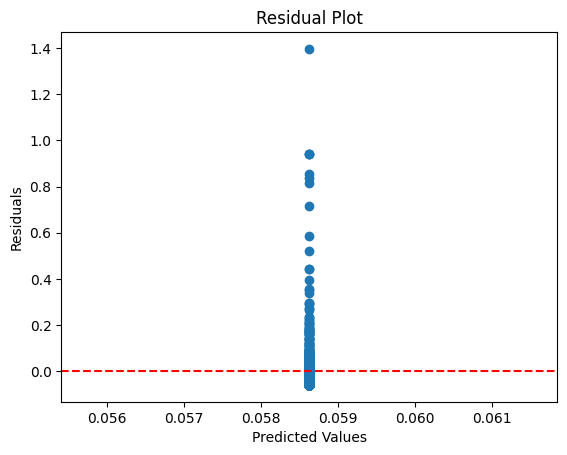

In [56]:
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

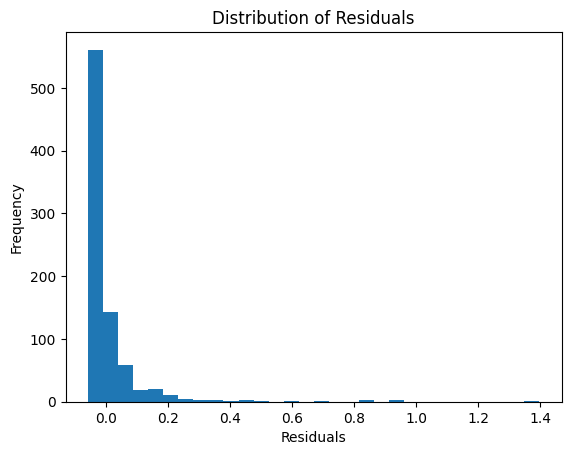

In [57]:
plt.hist(residuals, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

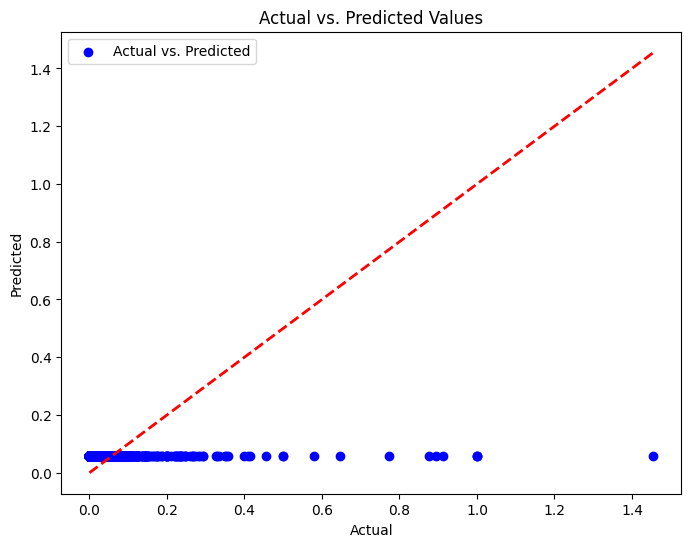

In [60]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [24]:
# Save the model
with open(os.path.join(os.getenv('TRAINED_MODELS_PATH'), 'decision_tree_model.pkl'), 'wb') as f:
    pickle.dump(best_model, f)